## Configuration for Colab

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !apt-get install -y xvfb python-opengl > /dev/null 2>&1
    !pip install gym pyvirtualdisplay > /dev/null 2>&1
    !pip install JSAnimation==0.1
    !pip install pyglet==1.3.2
    
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

# 04. PPO

- PPO: [J. Schulman et al., "Proximal Policy Optimization Algorithms." arXiv preprint arXiv:1707.06347, 2017.](https://arxiv.org/abs/1707.06347.pdf)
- TRPO: [Schulman, John, et al. "Trust region policy optimization." International conference on machine learning. 2015.](http://proceedings.mlr.press/v37/schulman15.pdf)

There are two kinds of algorithms of PPO: PPO-Penalty and PPO-Clip. Here, we'll implement PPO-clip version.

TRPO computes the gradients with a complex second-order method. On the other hand, PPO tries to solve the problem with a first-order methods that keep new polices close to old. To simplify the surrogate objective, let $r(\theta)$ denote the probability ratio

$$ L^{CPI}(\theta) = \hat {\mathbb{E}}_t \left [ {\pi_\theta(a_t|s_t) \over \pi_{\theta_{old}}(a_t|s_t)} \hat A_t\right] = \hat {\mathbb{E}}_t \left [ r_t(\theta) \hat A_t \right ].$$

The objective is penalized further away from $r_t(\theta)$

$$ L^{CLIP}(\theta)=\hat {\mathbb{E}}_t \left [ \min(r_t(\theta) \hat A_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat A_t) \right ] $$

If the advantage is positive, the objective will increase. As a result, the action becomes more likely. If advantage is negative, the objective will decrease. AS a result, the action becomes less likely.

## Import modules

In [2]:
import random
from collections import deque
from typing import Deque, Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Normal

## Set random seed

In [3]:
seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Network
We will use two separated networks for actor and critic respectively. The actor network consists of two fully connected hidden layer with ReLU branched out two fully connected output layers for mean and standard deviation of Gaussian distribution. Pendulum-v0 has only one action which has a range from -2 to 2. In order to fit the range, the actor outputs the mean value with tanh. The result will be scaled in ActionNormalizer class. On the one hand, the critic network has three fully connected layers as two hidden layers (ReLU) and an output layer. One thing to note is that we initialize the last layers' weights and biases as uniformly distributed.

In [4]:
def init_layer_uniform(layer: nn.Linear, init_w: float = 3e-3) -> nn.Linear:
    """Init uniform parameters on the single layer."""
    layer.weight.data.uniform_(-init_w, init_w)
    layer.bias.data.uniform_(-init_w, init_w)

    return layer


class Actor(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(Actor, self).__init__()

        self.hidden = nn.Linear(in_dim, 128)

        self.mu_layer = nn.Linear(128, out_dim)
        self.mu_layer = init_layer_uniform(self.mu_layer)

        self.log_std_layer = nn.Linear(128, out_dim)
        self.log_std_layer = init_layer_uniform(self.log_std_layer)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden(state))
        
        mu = torch.tanh(self.mu_layer(x)) * 2
        std = torch.ones_like(mu)

        dist = Normal(mu, std)
        action = dist.sample()

        return action, dist


class Critic(nn.Module):
    def __init__(self, in_dim: int):
        """Initialization."""
        super(Critic, self).__init__()

        self.hidden = nn.Linear(in_dim, 128)
        self.out = nn.Linear(128, 1)
        self.out = init_layer_uniform(self.out)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden(state))
        value = self.out(x)

        return value

## GAE

GAE help to reduce variance while maintaining a proper level of bias. By adjusting parameters $\lambda \in [0, 1]$ and $\gamma \in [0, 1]$. Please see [the paper](https://arxiv.org/pdf/1506.02438)

In [5]:
def compute_gae(
    next_value: list, 
    rewards: list, 
    masks: list, 
    values: list, 
    gamma: float, 
    tau: float
) -> List:
    """Compute gae."""
    values = values + [next_value]
    gae = 0
    returns: Deque[float] = deque()

    for step in reversed(range(len(rewards))):
        delta = (
            rewards[step]
            + gamma * values[step + 1] * masks[step]
            - values[step]
        )
        gae = delta + gamma * tau * masks[step] * gae
        returns.appendleft(gae + values[step])

    return list(returns)

PPO updates the model several times(`epoch`) using the stacked memory. By `ppo_iter` function, It yield the samples of stacked memory by interacting a environment.

In [6]:
def ppo_iter(
    epoch: int,
    mini_batch_size: int,
    states: torch.Tensor,
    actions: torch.Tensor,
    values: torch.Tensor,
    log_probs: torch.Tensor,
    returns: torch.Tensor,
    advantages: torch.Tensor,
):
    """Yield mini-batches."""
    batch_size = states.size(0)
    for _ in range(epoch):
        for _ in range(batch_size // mini_batch_size):
            rand_ids = np.random.choice(batch_size, mini_batch_size)
            yield states[rand_ids, :], actions[rand_ids], values[
                rand_ids
            ], log_probs[rand_ids], returns[rand_ids], advantages[rand_ids]

## PPO Agent
Here is a summary of PPOAgent class.

| Method           | Note                                                 |
|---               |---                                                   |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|_plot             | plot the training progresses.                        |


In [7]:
class PPOAgent:
    """PPO Agent.
    Attributes:
        env (gym.Env): Gym env for training
        gamma (float): discount factor
        tau (float): lambda of generalized advantage estimation (GAE)
        batch_size (int): batch size for sampling
        epsilon (float): amount of clipping surrogate objective
        epoch (int): the number of update
        rollout_len (int): the number of rollout
        entropy_weight (float): rate of weighting entropy into the loss function
        actor (nn.Module): target actor model to select actions
        critic (nn.Module): critic model to predict state values
        transition (list): temporory storage for the recent transition
        device (torch.device): cpu / gpu
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)        
    """

    def __init__(
        self,
        env: gym.Env,
        batch_size: int,
        gamma: float,
        tau: float,
        epsilon: float,
        epoch: int,
        rollout_len: int,
        entropy_weight: float,
    ):
        """Initialize."""
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch = epoch
        self.rollout_len = rollout_len
        self.entropy_weight = entropy_weight

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.critic = Critic(obs_dim).to(self.device)

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.005)

        # memory for training
        self.states: List[torch.Tensor] = []
        self.actions: List[torch.Tensor] = []
        self.rewards: List[torch.Tensor] = []
        self.values: List[torch.Tensor] = []
        self.masks: List[torch.Tensor] = []
        self.log_probs: List[torch.Tensor] = []

        # total steps count
        self.total_step = 1

        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        state = torch.FloatTensor(state).to(self.device)
        action, dist = self.actor(state)
        selected_action = dist.mean if self.is_test else action

        if not self.is_test:
            value = self.critic(state)
            self.states.append(state)
            self.actions.append(selected_action)
            self.values.append(value)
            self.log_probs.append(dist.log_prob(selected_action))

        return selected_action.cpu().detach().numpy()

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)
        next_state = np.reshape(next_state, (1, -1)).astype(np.float64)
        reward = np.reshape(reward, (1, -1)).astype(np.float64)
        done = np.reshape(done, (1, -1))

        if not self.is_test:
            self.rewards.append(torch.FloatTensor(reward).to(self.device))
            self.masks.append(torch.FloatTensor(1 - done).to(self.device))

        return next_state, reward, done

    def update_model(
        self, next_state: np.ndarray
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines

        next_state = torch.FloatTensor(next_state).to(device)
        next_value = self.critic(next_state)

        returns = compute_gae(
            next_value,
            self.rewards,
            self.masks,
            self.values,
            self.gamma,
            self.tau,
        )

        states = torch.cat(self.states).view(-1, 3)
        actions = torch.cat(self.actions)
        returns = torch.cat(returns).detach()
        values = torch.cat(self.values).detach()
        log_probs = torch.cat(self.log_probs).detach()
        advantages = returns - values

        actor_losses, critic_losses = [], []

        for state, action, old_value, old_log_prob, return_, adv in ppo_iter(
            epoch=self.epoch,
            mini_batch_size=self.batch_size,
            states=states,
            actions=actions,
            values=values,
            log_probs=log_probs,
            returns=returns,
            advantages=advantages,
        ):
            # calculate ratios
            _, dist = self.actor(state)
            log_prob = dist.log_prob(action)
            ratio = (log_prob - old_log_prob).exp()

            # actor_loss
            surr_loss = ratio * adv
            clipped_surr_loss = (
                torch.clamp(ratio, 1.0 - self.epsilon, 1.0 + self.epsilon) * adv
            )

            # entropy
            entropy = dist.entropy().mean()

            actor_loss = (
                -torch.min(surr_loss, clipped_surr_loss).mean()
                - entropy * self.entropy_weight
            )

            # critic_loss
            value = self.critic(state)
            clipped_value = old_value + (value - old_value).clamp(-0.5, 0.5)
            critic_loss = (return_ - clipped_value).pow(2).mean()
        
            # train critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1.0)
            self.critic_optimizer.step()

            # train actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1.0)
            self.actor_optimizer.step()

            actor_losses.append(actor_loss.item())
            critic_losses.append(critic_loss.item())

        self.states, self.actions, self.rewards = [], [], []
        self.values, self.masks, self.log_probs = [], [], []

        actor_loss = sum(actor_losses) / len(actor_losses)
        critic_loss = sum(critic_losses) / len(critic_losses)

        return actor_loss, critic_loss

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False

        state = self.env.reset()
        state = np.expand_dims(state, axis=0)

        actor_losses, critic_losses = [], []
        scores = []
        score = 0

        while self.total_step <= num_frames + 1:
            for _ in range(self.rollout_len):
                self.total_step += 1
                action = self.select_action(state)
                next_state, reward, done = self.step(action)

                state = next_state
                score += reward[0][0]

                # if episode ends
                if done[0][0]:
                    state = env.reset()
                    state = np.expand_dims(state, axis=0)
                    scores.append(score)
                    score = 0

                    self._plot(
                        self.total_step, scores, actor_losses, critic_losses
                    )

            actor_loss, critic_loss = self.update_model(next_state)
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)

        # termination
        self.env.close()

    def test(self):
        """Test the agent."""
        self.is_test = True

        state = self.env.reset()
        done = False
        score = 0

        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        return frames

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        actor_losses: List[float],
        critic_losses: List[float],
    ):
        """Plot the training progresses."""

        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

## Environment
**ActionNormalizer** is an action wrapper class to normalize the action values ranged in (-1. 1). Thanks to this class, we can make the agent simply select action values within the zero centered range (-1, 1).

In [8]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

You can see [the code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py) and [configurations](https://github.com/openai/gym/blob/cedecb35e3428985fd4efad738befeb75b9077f1/gym/envs/__init__.py#L81) of Pendulum-v0 from OpenAI's repository.

In [9]:
# environment
env_id = "Pendulum-v0"
env = gym.make(env_id)
env = ActionNormalizer(env)
env.seed(seed)

[777]

## Initialize

In [10]:
# parameters
num_frames = 150000

agent = PPOAgent(
    env,
    gamma = 0.96,
    tau = 0.9,
    batch_size = 64,
    epsilon = 0.2,
    epoch = 128,
    rollout_len = 128,
    entropy_weight = 0.005
)

cuda


## Train

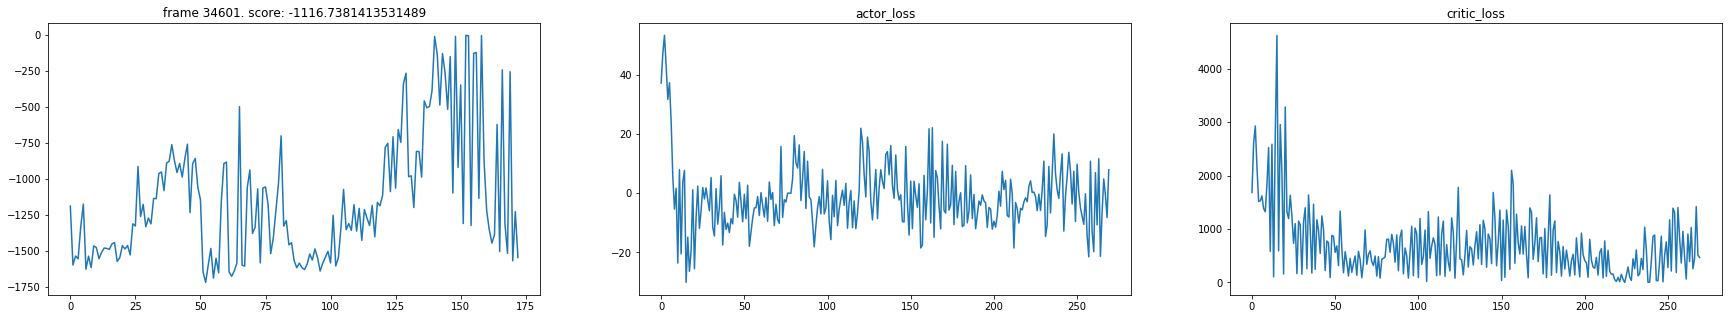

In [ ]:
agent.train(num_frames)

## Test

In [ ]:
frames = agent.test()

## Render

In [ ]:
# Imports specifically so we can render outputs in Colab.
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display


def display_frames_as_gif(frames):
    """Displays a list of frames as a gif, with controls."""
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(
        plt.gcf(), animate, frames = len(frames), interval=50
    )
    display(display_animation(anim, default_mode='loop'))
    
        
# display 
display_frames_as_gif(frames)